<h1><center><br/>Wind-dependent Variables: Predict Wind<br/>Speeds of Tropical Storms</center></h1>

<font size="3">
    <center>
        Trustworthy AI for Environmental Science
        <br/>
        Summer School Trust-A-Thon
        <br/>
        <br/>
        June 27-30, 2022
        <br/>
        <br/>
        <i>Authors: Jason Stock, Akansha Singh Bansal</i>
    </center>
</font>

Tropical cyclones are some of the most expensive weather disasters in terms of both economic damages and loss of human life. Tropical cyclone forecasts typically consist of 2 parts--a track forecast (predicting <b>where</b> the center of the tropical cyclone will go) and an intensity forecast (predicting <b>how strong</b> the strongest winds will be). ![fooo](/intensity_forecasts.jpg).

In previous decades, forecasters have estimated tropical cyclone intensity using the Dvorak technique, which requires each individual forecaster to identify patterns in tropical storms based on visual identification of cloud features in visible and infrared satellite imagery. As you can imagine, this is pretty labor-intensive, and subjective to the interpretation of each individual forecaster! The hope is that an accurate machine learning-based model would be faster, automated, and more objective than relying on human forecasters.

# Table of Contents

* ---------------- [DAY 1](#DAY-1) ----------------
    * [Downloading the Data](#Downloading-the-Data)
    * [Explore the Data](#Explore-the-Data)
    * [Required Functions](#Required-Functions)
    * [Linear Regression](#Linear-Regression)
        * [Model Visualizations](#Model-Visualizations)
        * [Permutation Importance](#Permutation-Importance)
        * [Shapley Values](#Shapley-Values)
* ---------------- [DAY 2](#DAY-2) ----------------
    * [Convolutional Neural Network](#Convolutional-Neural-Network)
        * [Network Visualizations](#Network-Visualizations)
        * [Saliency](#Saliency)    
* ---------------- [DAY 3](#DAY-3) ----------------
    * [Case Studies](#Case-Studies)
        * [NN performance as a function of storm type](#Storm-Type)
        * [NN performance as a function of ocean basin](#Geographic-exploration)

---

In [1]:
# non-standard dependencies
!pip install shap saliency radiant-mlhub

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import json
import time
import copy
import tqdm
import shap
import random
import tarfile
import urllib.request

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.colors
import matplotlib.pyplot as plt
import saliency.core as saliency

from glob import glob
from PIL import Image
from pathlib import Path
from IPython.display import HTML
from matplotlib import animation
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
from radiant_mlhub import Dataset, client

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Configuration

Specify the path location of where to download data with the `DATA_PATH` variable. The uncompressed data will require 5.3 GB of disk space.

In [3]:
DATA_PATH = Path('./tc-data') # relative or absolute path
DATA_PATH.mkdir(exist_ok=True)

A GPU is not required for this notebook. In fact, some experiments will run faster on the CPU over a GPU. If you choose to run with a GPU, then the following cell will initialize just the memory you need for the model. To configure a GPU in Google Colab:
   1. Navigate to `Edit -> Notebook Settings`, then
   2. select `GPU` from the `Hardware Accelerator` drop-down

In [4]:
# NOTE: only needs to run if running TensorFlow models on a GPU

# os.environ['CUDA_VISIBLE_DEVICES']='1' # uncomment if multiple GPUs are present
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')


# DAY 1

## Downloading the Data

In order to access the dataset from Radiant MLHub, you will need to register for an MLHub API key at https://mlhub.earth. In the *API Keys* tab, you'll be able to create API key(s), which you will need. Do not share your API key with anyone. 

One method to configure the client is to set the `MLHUB_API_KEY` environment variable. 

In [5]:
os.environ['MLHUB_API_KEY'] = 'PASTE_YOUR_API_KEY_HERE'

Radiant MLHub has a large collection of available datasets that we can inspect by `id`, `title`, and their `citation`. Here we filter results to show only the id's with NASA in the name, but there are many others available. 

In [6]:
for dataset in Dataset.list():
    if 'nasa' in dataset.id:
        print(f'{dataset.id}: ({dataset.title})\n{dataset.citation}\n')

nasa_marine_debris: (Marine Debris Dataset for Object Detection in Planetscope Imagery)
Shah, A., Thomas, L., & Maskey, M. (2021) "Marine Debris Dataset for Object Detection in Planetscope Imagery", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/rdnt.9r6ekg

nasa_floods_v1: (NASA Flood Extent Detection)
Gahlot, S., Gurung, I., Molthan, A., Maskey, M., & Ramasubramanian, M. (2021) "Flood Extent Data for Machine Learning", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/rdnt.ebk43x

nasa_tropical_storm_competition: (Tropical Cyclone Wind Estimation Competition)
M. Maskey, R. Ramachandran, I. Gurung, B. Freitag, M. Ramasubramanian, J. Miller"Tropical Cyclone Wind Estimation Competition Dataset", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/rdnt.xs53up



We're interested in the "Tropical Cyclone Wind Estimation Competition" dataset. We can fetch this dataset using its ID (i.e., `nasa_tropical_storm_competition`) and then use the `collections` property to list the source imagery and label collections associated with this dataset.

In [8]:
dataset = Dataset.fetch('nasa_tropical_storm_competition')

print('Source Imagery Collections\n--------------------------')
for collection in dataset.collections.source_imagery:
    print(collection.id)

print('')

print('Label Collections\n-----------------')
for collection in dataset.collections.labels:
    print(collection.id)

Source Imagery Collections
--------------------------
nasa_tropical_storm_competition_train_source
nasa_tropical_storm_competition_test_source

Label Collections
-----------------
nasa_tropical_storm_competition_train_labels
nasa_tropical_storm_competition_test_labels


This dataset has two collections, one containing the source imagery and the other with labels.

The following cell gets the first item from each collection and prints the item ID, as well as a summary of the assets associated with the item.

### NOTE that since we are hosting the data locally, this cell has been switched to Markdown.  Feel free to uncomment it if you would like to see more about the process of getting data from Radiantearth. 

<code>
def print_summary(item, collection):
    print(f'Collection: {collection.id}')
    print(f'Item: {item["id"]}')
    print('Assets:')
    for asset_name, asset in item.get('assets', {}).items():
        print(f"- {asset_name}: {asset['title']} [{asset['type']}]")
    
    print('\n')

for collection in dataset.collections:
    item = next(client.list_collection_items(collection.id, limit=1))
    print_summary(item, collection)
</code>

### Update 6/21:  
Taking too long to download files from radiant-earth, so we are hosting them locally via a Google storage bucket.  Files are downloaded, unzipped, and saved locally.  To download from radiant-earth, swap in the following lines:
<code>
archive_paths = dataset.download(output_dir=DATA_PATH, if_exists='resume')
for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=DATA_PATH)
print('Done')
</code>

Items in the `*train_label`s collection have a "labels" JSON asset containing wind speed targets for each source image. Items in the `*test_source` and `*train_source` collections have both a "features" JSON asset containing image features as JSON and an "image" JPEG asset.

In the following cells, we download all assets (labels and images) for both the test and train collections. 

# NOTE: Extracting the archives takes a while so this cell may take a few minutes to complete

In [23]:
fpath_head = "https://storage.googleapis.com/tai4es-trustathon-2022/nasa_tropical_storm_competition"
file_names = ['.tar.gz','_train_source.tar.gz','_train_labels.tar.gz','_test_source.tar.gz','_test_labels.tar.gz']
#
for ifile in file_names:
    the_tar = fpath_head+ifile
    print('opening ',the_tar)
    ftpstream = urllib.request.urlopen(the_tar)
    with tarfile.open(fileobj=ftpstream, mode="r|gz") as tfile:
        tfile.extractall(path=DATA_PATH)
    print('extracted to ',DATA_PATH)

#with tarfile.open('https://storage.googleapis.com/tai4es-trustathon-2022/nasa_tropical_storm_competition_train_source.tar.gz') as tfile:
 #   tfile.extractall(path=DATA_PATH)

opening  https://storage.googleapis.com/tai4es-trustathon-2022/nasa_tropical_storm_competition.tar.gz
extracted to  tc-data
opening  https://storage.googleapis.com/tai4es-trustathon-2022/nasa_tropical_storm_competition_train_source.tar.gz
extracted to  tc-data
opening  https://storage.googleapis.com/tai4es-trustathon-2022/nasa_tropical_storm_competition_train_labels.tar.gz
extracted to  tc-data
opening  https://storage.googleapis.com/tai4es-trustathon-2022/nasa_tropical_storm_competition_test_source.tar.gz
extracted to  tc-data
opening  https://storage.googleapis.com/tai4es-trustathon-2022/nasa_tropical_storm_competition_test_labels.tar.gz
extracted to  tc-data


After downloading and extracting the individual archives, we will load the training and test data into individual `DataFrame`s. These will contain all the information corresponding to a given image, including the target wind speed.

In [24]:
def load_data(dataset: str) -> pd.DataFrame:
    data = []

    source = f'nasa_tropical_storm_competition_{dataset}_source'
    labels = f'nasa_tropical_storm_competition_{dataset}_labels'

    jpg_names = glob(str(DATA_PATH / source / '**' / '*.jpg'))

    for jpg_path in jpg_names:
        jpg_path = Path(jpg_path)
        
        # Get the IDs and file paths
        features_path = jpg_path.parent / 'features.json'
        image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
        storm_id = image_id.split('_')[0]
        labels_path = str(jpg_path.parent / 'labels.json').replace(source, labels)

        # Load the features data
        with open(features_path) as src:
            features_data = json.load(src)

        # Load the labels data
        with open(labels_path) as src:
            labels_data = json.load(src)

        data.append([
            image_id, 
            storm_id, 
            int(features_data['relative_time']), 
            int(features_data['ocean']), 
            float(labels_data['wind_speed']),
            jpg_path,
        ])

    df = pd.DataFrame(
        np.array(data),
        columns=['image_id', 'storm_id', 'relative_time', 'ocean', 'wind_speed', 'file_name']
    ).sort_values(by=['image_id']).reset_index(drop=True)
    
    # Add a column for percentage of storm by time step
    images_per_storm = df.groupby('storm_id').size().to_frame('images_per_storm')
    df = df.merge(images_per_storm, how='left', on='storm_id')

    df['pct_of_storm'] = (
        df.groupby('storm_id').cumcount() / df.images_per_storm
    )
    
    return df

In [25]:
train_df = load_data('train')
train_df.head()

image_id storm_id relative_time ocean wind_speed  \
0  abs_000      abs             0     2       43.0   
1  abs_001      abs          1800     2       44.0   
2  abs_002      abs          5400     2       45.0   
3  abs_003      abs         17999     2       52.0   
4  abs_004      abs         19799     2       53.0   

                                           file_name  images_per_storm  \
0  tc-data/nasa_tropical_storm_competition_train_...                57   
1  tc-data/nasa_tropical_storm_competition_train_...                57   
2  tc-data/nasa_tropical_storm_competition_train_...                57   
3  tc-data/nasa_tropical_storm_competition_train_...                57   
4  tc-data/nasa_tropical_storm_competition_train_...                57   

   pct_of_storm  
0      0.000000  
1      0.017544  
2      0.035088  
3      0.052632  
4      0.070175

In [26]:
test_df = load_data('test')
test_df.head()

image_id storm_id relative_time ocean wind_speed  \
0  acd_123      acd        304198     1       34.0   
1  acd_124      acd        305998     1       34.0   
2  acd_125      acd        307798     1       33.0   
3  acd_126      acd        309598     1       33.0   
4  acd_127      acd        313198     1       32.0   

                                           file_name  images_per_storm  \
0  tc-data/nasa_tropical_storm_competition_test_s...               101   
1  tc-data/nasa_tropical_storm_competition_test_s...               101   
2  tc-data/nasa_tropical_storm_competition_test_s...               101   
3  tc-data/nasa_tropical_storm_competition_test_s...               101   
4  tc-data/nasa_tropical_storm_competition_test_s...               101   

   pct_of_storm  
0      0.000000  
1      0.009901  
2      0.019802  
3      0.029703  
4      0.039604

Let's save the `train_df` and `test_df` to the current directory so that we can easily load the metadata again.

In [27]:
train_df.to_csv(DATA_PATH / 'train_metadata.csv', index=False)
test_df.to_csv(DATA_PATH / 'test_metadata.csv', index=False)

## Explore the Data

We will now explore the data and the features we have to work with. First, let's load the metadata for the training and test data so that we don't have to filter through all the source files again.

In [28]:
train_df = pd.read_csv(DATA_PATH / 'train_metadata.csv')
test_df = pd.read_csv(DATA_PATH / 'test_metadata.csv')
train_df.shape, test_df.shape

((70257, 8), (44377, 8))

In [29]:
train_df.columns

Index(['image_id', 'storm_id', 'relative_time', 'ocean', 'wind_speed',
       'file_name', 'images_per_storm', 'pct_of_storm'],
      dtype='object')

The `DataFrame`s consist of image metadata identified by a unique `image_id`. Each `image_id` is composed of `{storm_id}_{image_number}`, where `storm_id` is a unique three letter code and `image_number` represents the sequential ordering of images throughout that storm. The `file_name` holds the location of the JPEG image for a given sample and the `wind_speed` feature is the ground truth value.

Let's take a look at how many storms are in the training data, and how many images we have per storm.

In [30]:
storm_counts = train_df.groupby('storm_id').size()
storm_counts.describe()

count    494.000000
mean     142.220648
std      123.151772
min        4.000000
25%       46.250000
50%      101.500000
75%      209.000000
max      648.000000
dtype: float64

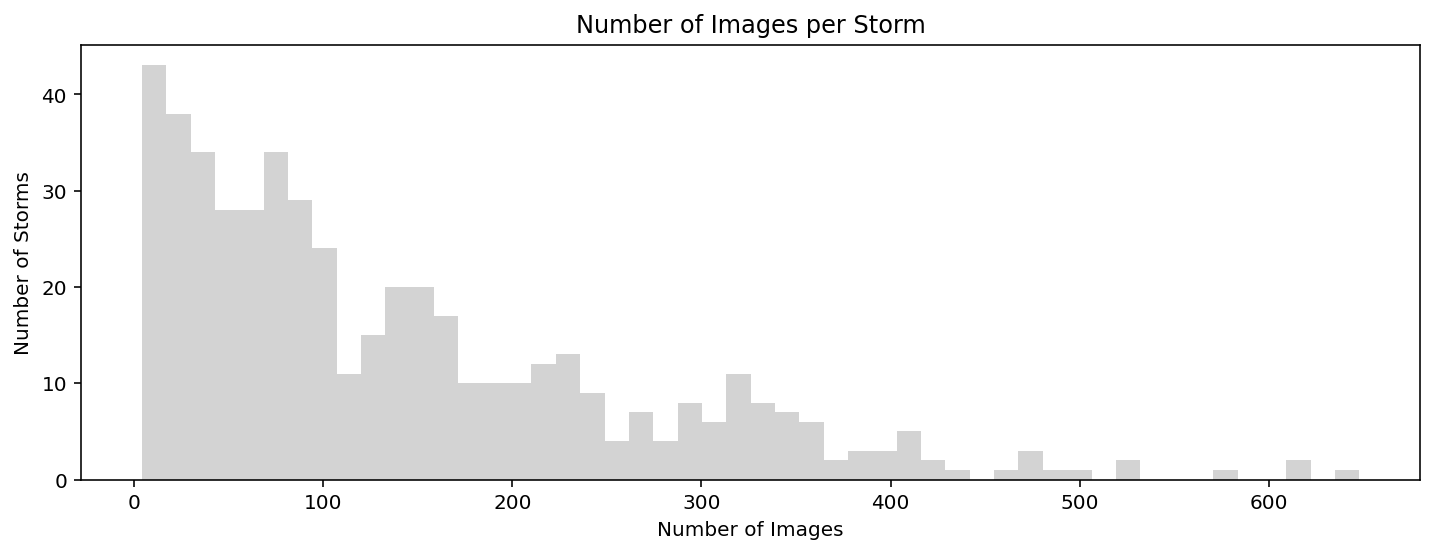

In [31]:
plt.figure(figsize=(12, 4))
plt.hist(storm_counts, bins=50, color='lightgray')
plt.xlabel('Number of Images')
plt.ylabel('Number of Storms')
plt.title('Number of Images per Storm')
plt.show()

The training data contain images from 494 storms. We have anywhere from 4 (`storm_counts.min()`) to 648 (`storm_counts.max()`) images per unique storm, with many storms containing fewer than 100 images.

We can also take a look at how many storms come from each ocean.

In [32]:
train_df.groupby('ocean')['storm_id'].nunique()

ocean
1    264
2    230
Name: storm_id, dtype: int64

Next, let's explore the overall distribution of wind speeds in the training data by looking at the `wind_speed` features.

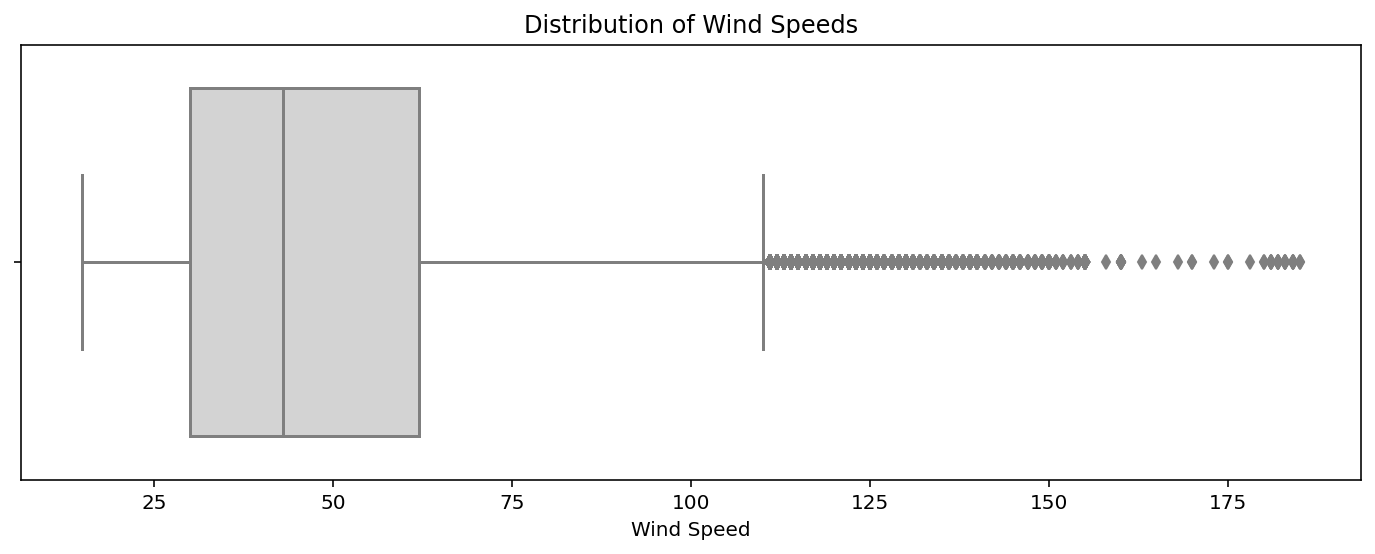

In [33]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=train_df.wind_speed, color='lightgray')
plt.xlabel('Wind Speed')
plt.title('Distribution of Wind Speeds')
plt.show()

Wind speeds in the training data range from 15 to 185 knots. A majority of images fall between 30 and 62 knots, but given what we know about storm intensity, it is especially important that we be able to accurately estimate the highest wind speeds. Most of which are statistical outliers, i.e. $t > Q3 + 1.5 * IQR$, and something to keep ind mind.

Given the temporal nature of storm and wind patterns, relative time will be an important correlate of wind speed. Our metadata contains a relative time field measured in seconds since the beginning of a storm. We can make a scatter plot to see how wind speeds change over the course of a storm for a couple of examples.

In [34]:
def plot_wind_speeds(storm_id, df):
    storm = df[df.storm_id == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter('relative_time', 'wind_speed', data=storm, color='lightgray')
    plt.ticklabel_format(useOffset=False)
    plt.ylabel('Wind Speed (kt)')
    plt.xlabel('Relative Time')
    plt.title(f'Wind Speed over Relative Time: Storm {storm_id}')
    plt.show()

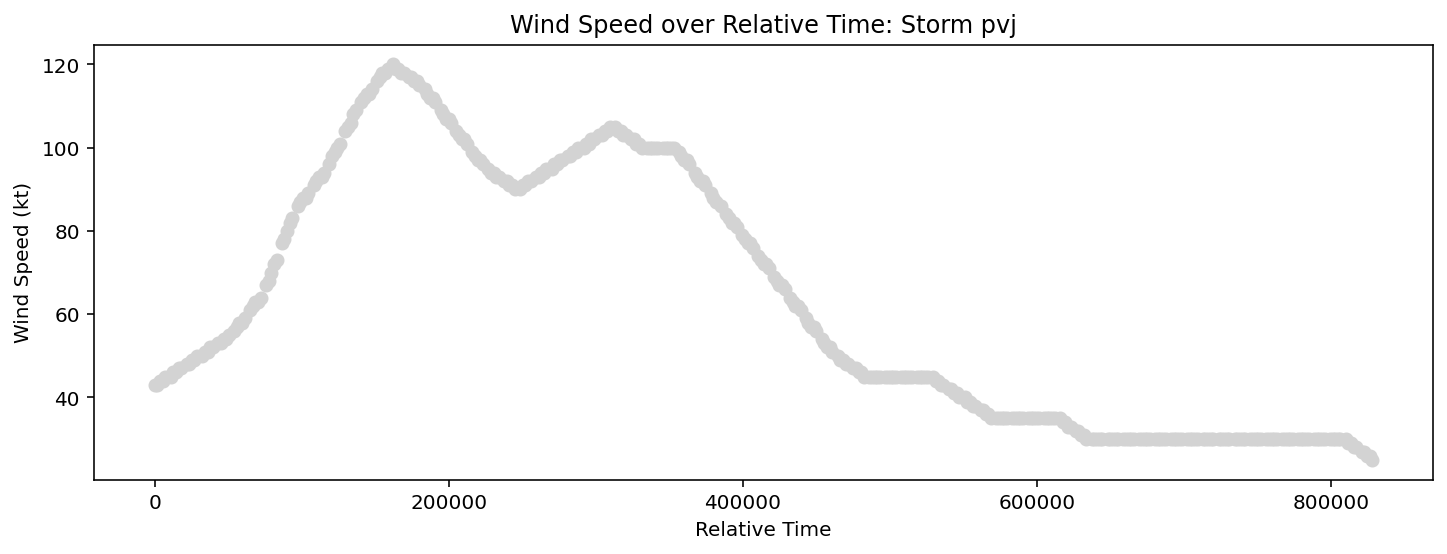

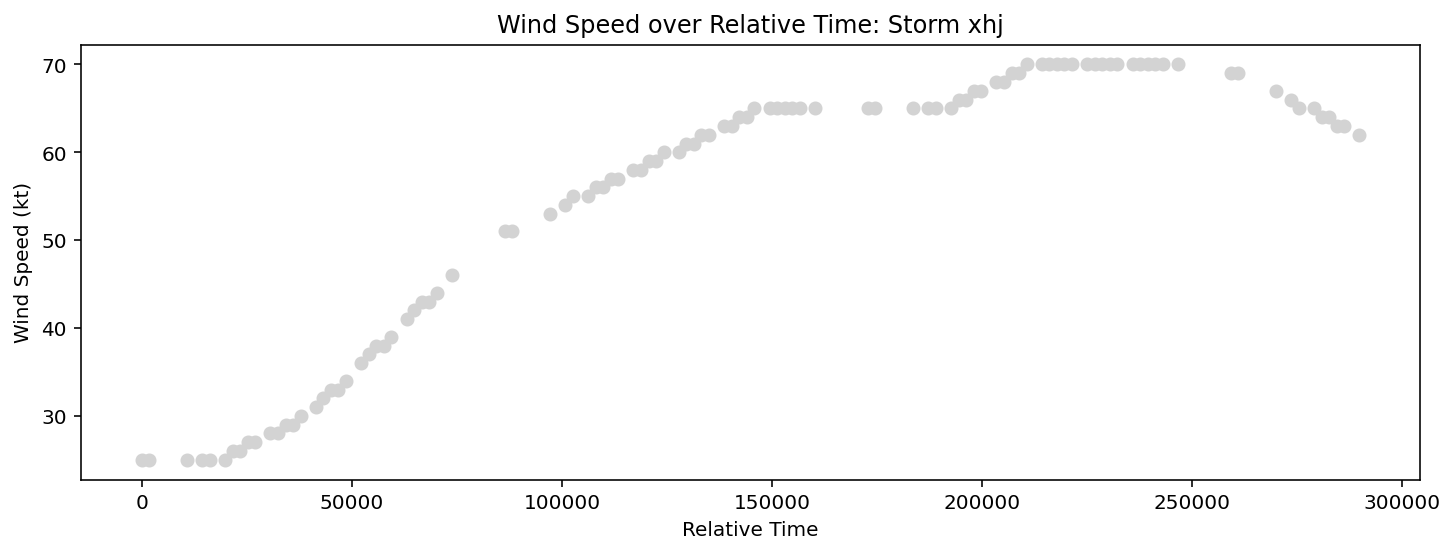

In [35]:
# Sample two random storms from full_metadata
for storm in train_df.storm_id.sample(2, random_state=40):
    plot_wind_speeds(storm, train_df)

For storm `pvj`, wind speeds begin around 40 knots, steadily increase to 120 knots, and then drop off again. Storm `xhj` displays a similar pattern, except that wind speeds hover around 70 knots before dropping off. While there appear to be short periods of time for which we do not have images available for these two storms, there is a clear relationship between relative time and wind speed.

Keep in mind that the test set contains storms not represented in the training set, so our model needs to be able to generalize to storms it hasn't seen before. For storms represented in both the training and test sets, the test set images always temporally succeed the training set images.

### Images

Next, we can begin exploring the image data. The data are single-band infrared images captured by Geostationary Operational Environmental Satellites (GOES)-16, pixel values represent heat energy in the infrared spectrum. Data for this competition come from band-13 ($10.3 \mu m$). We will be able to see objects, like weather clouds, based on their temperatures, but these representations are actually invisible to the human eye.

In [36]:
def look_at_wind_speed(wind_speed):
    sample_img = train_df[train_df.wind_speed == wind_speed].file_name.iloc[0]
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    with Image.open(sample_img) as im:
        ax.imshow(im, cmap='gray')
        ax.text(5, 25, f'{wind_speed} kt', color='yellow', weight='bold', fontsize=14)
        ax.axis('off')

What does a relatively low wind speed image look like?

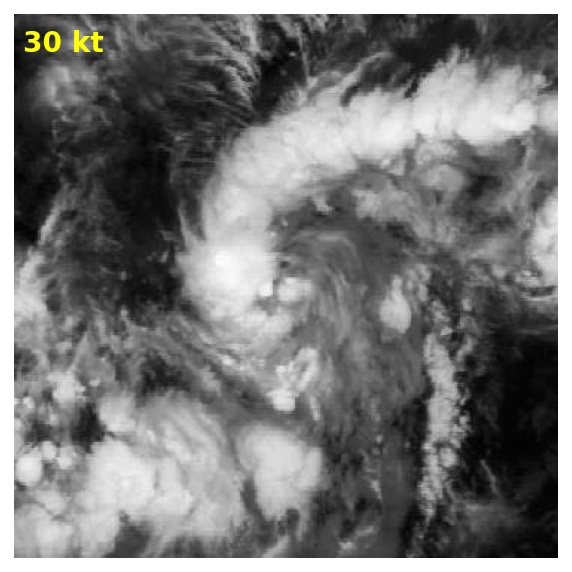

In [37]:
look_at_wind_speed(wind_speed=30)

How about a relatively high wind speed image?

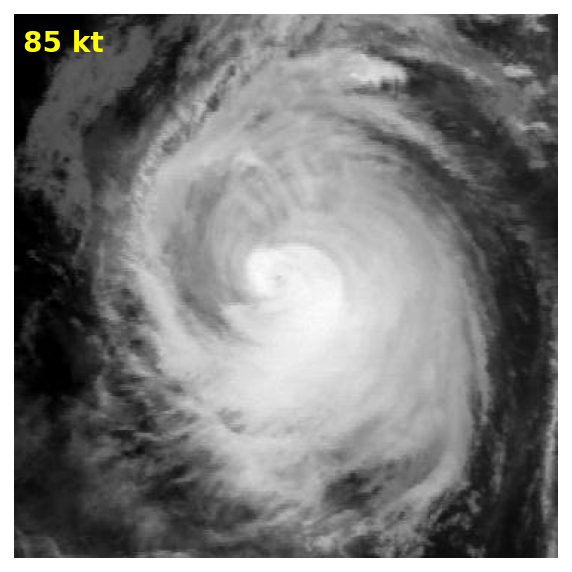

In [38]:
look_at_wind_speed(wind_speed=85)

Interesting! How about the image with the highest wind speed?

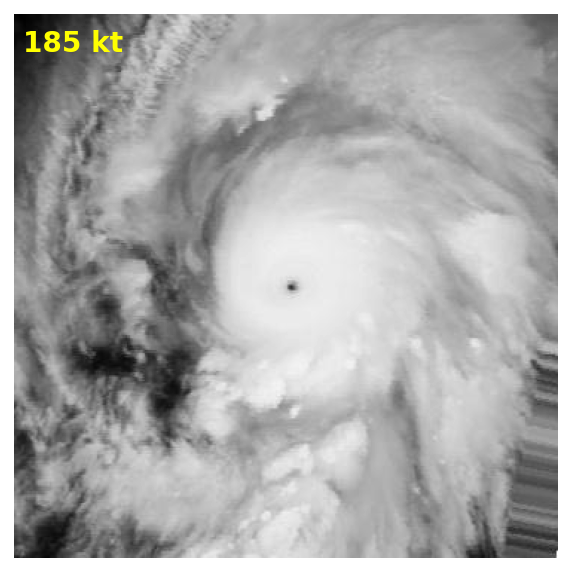

In [39]:
look_at_wind_speed(wind_speed=185)

With each increase in wind speed, we can see noticeable changes in storm structure and intensity. An effective model will be able to detect these types of patterns at scale. 

Now, let's create an animation for a given storm, indexed by the `storm_id`, showing `n_frames` equally spaced from the start to the end. We can do this for any storm in the dataset. The cell below shows a subset of the storms to select from. Try changing the `storm_id` variable to visualize animations of the other storms.

In [40]:
train_df.storm_id.unique()[:15]

array(['abs', 'acd', 'aek', 'afs', 'agl', 'aja', 'akq', 'alc', 'alq',
       'amd', 'amn', 'amw', 'amz', 'ang', 'ano'], dtype=object)

In [41]:
## Animation of wind speeds

storm_id = 'bcf'
n_frames = 50

# -----------------------
# build animation
fig, ax = plt.subplots(1,1,figsize=(5, 5))

storm = train_df[train_df.storm_id == storm_id]
if n_frames <= len(storm):
    inds = np.round(np.linspace(0, len(storm)-1, n_frames)).astype(int)
    storm = storm.iloc[inds]
else:
    n_frames = len(storm)

def update(i):
    storm_frame = storm.iloc[i]
    x = Image.open(storm_frame.file_name)
    t = storm_frame.wind_speed
    ax.imshow(x, cmap='gray')
    ax.set_title(f'{storm_frame.storm_id} ({int(storm_frame.pct_of_storm*100)}%)', 
                 fontsize=13, fontweight='bold', loc='left')
    ax.set_title(f't={t}', fontsize=13)
    ax.axis('off')
        
    if i == 0:
        fig.tight_layout()
        
anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=125)
# anim.save('tc_animation.mp4', fps=15, dpi=300)
plt.close()
HTML(anim.to_jshtml())

### Partitioning the Data

The test set for this competition includes a set of storms not included in the training data, as well as unseen imagery from later in a training storm's life cycle. We do not want to overstate our model's performance by overfitting to one or more storms. To be sure that our method is sufficiently generalizable, we will set aside a portion of the training imagery to validate the model during its development.

Since observations in a time series are not independent, we cannot randomly subset the training data into training and validation sets. In other words, the characteristics of temporal data, such as trends and seasonality, require that we take time into account when splitting the data. From a real-world perspective, it will always be the case that we will use images and wind measurements taken earlier in a storm to estimate wind speeds when new imagery comes in.

To account for the temporal relationship of the data up to the point of prediction and to ensure that we are not using images captured later in a storm to estimate prior wind speeds, we will subset the training data into training and validation sets using the relative_time field. For the purposes of this benchmark, we will holdout the last 20% of each storm's available images for our validation set.

In [42]:
# Identify the final 20% of images per storm
train = train_df[train_df.pct_of_storm < 0.8].drop(
    ['images_per_storm', 'pct_of_storm'], axis=1
)
val = train_df[train_df.pct_of_storm >= 0.8].drop(
    ['images_per_storm', 'pct_of_storm'], axis=1
)

In [43]:
# Confirm pct of images in the validation set is approximately 20%
len(val) / len(train_df) * 100

19.734688358455386

For the purposes of this notebook, we will use a randomly selected subset of 10% of our available data for training and validation. This adjustment will increase performance as we build our initial pipeline, but can be adjusted back for final training.

In [44]:
# Sample 10% to increase performance
train = train.sample(frac=0.1, replace=False, random_state=1).reset_index(drop=True)
val = val.sample(frac=0.1, replace=False, random_state=1).reset_index(drop=True)
test = test_df.sample(frac=0.1, replace=False, random_state=1).reset_index(drop=True)
train.shape, val.shape, test.shape

((5639, 6), (1386, 6), (4438, 8))

## Required Functions

There are a number of **required** functions defined in the following subsections that we will be using throughout the remainder of the notebook:

- [Data Loading](#Data-Loading): implements functions to streamline the process of splitting the data and loading images and target values.
- [Network Class](#Network-Class): a comprehensive class for standardizing data and training linear, fully-connected, and convolutional networks for regression tasks.
- [Additional Plotting](#Additional-Plotting): functions to plot results of individual models.

**! IMPORTANT**: be sure to run these cells before the [Day 2](#Day-2) and [Day 3](#Day-3) activites.

### Data Loading 

In [45]:
W, H = 128, 128  # global width and height for image resolution

def partition_data(train_df, test_df, sample_frac=0.1, state=1):
    """Split and sample DataFrames 

    :param train_df: _training_ df that is to be split 
        (to validation) and sampled
    :param test_df:  _test_ df that is to be sampled
    :param sample_frac: fraction of data to sample from df
    :param state: random state used for repeatable sampling
    :return: train: _training_ df split with all metadata features
    :return: val: _validation_ df split with all metadata features
    :return: test: _test_ df with all metadata features
    """
    # Identify the final 20% of images per storm
    train = train_df[train_df.pct_of_storm < 0.8].drop(
        ['images_per_storm', 'pct_of_storm'], axis=1
    )
    val = train_df[train_df.pct_of_storm >= 0.8].drop(
        ['images_per_storm', 'pct_of_storm'], axis=1
    )
    
    # Sample fraction to increase performance
    train = train.sample(frac=sample_frac, replace=False, 
                         random_state=state).reset_index(drop=True)
    val = val.sample(frac=sample_frac, replace=False, 
                     random_state=state).reset_index(drop=True)
    test = test_df.sample(frac=sample_frac, replace=False, 
                          random_state=state).reset_index(drop=True)
    
    return train, val, test

def read_images(files, threads=12):
    """Read images by filenames to a numpy array

    N = number of images
    W = width of images
    H = height of images
    C = number of channels 

    :param files: list of files to read
    :param threads: number of threads to use for reading
    :return: images: (N,W,H,C) numpy array of images
    """
    def _reading_thread(files, n_images, section):
        """Helper function for reading in different threads"""
        for i,f in enumerate(files[section:section+n_images]):
            with Image.open(f).convert('L') as im:
                images[i+section] = np.expand_dims(im.resize((W,H)), axis=-1) / 255.

    images = np.zeros((len(files), W, H, 1))
    n_images = len(files) // threads
    with ThreadPoolExecutor(max_workers=threads) as executor:
        for section in [n_images * i for i in range(threads + 1)]:
            executor.submit(_reading_thread, files, n_images, section)
            
    return images

def load_data(train, val, test):
    """Convert DataFrame to numpy array for training, 
    validation, and test datasets

    F = number of target output features

    :param train: _training_ df with file_name and wind_speed variables 
    :param val: _validation_ df with file_name and wind_speed variables 
    :param test: _test_ df with file_name and wind_speed variables 
    :return: X_: (N,W,H,C) numpy array of _ images
    :return: T_: (N,F) numpy array of _ targets
    """
    Xtrain = read_images(train.file_name.values)
    Ttrain = train.wind_speed.values.reshape(-1,1)

    Xval = read_images(val.file_name.values)
    Tval = val.wind_speed.values.reshape(-1,1)

    Xtest = read_images(test.file_name.values)
    Ttest = test.wind_speed.values.reshape(-1,1)
    
    return Xtrain, Ttrain, Xval, Tval, Xtest, Ttest

def partition_and_load_data():
    """Helper function to load training, validation, and test datasets

    :return: X_: (N,W,H,C) numpy array of _ images
    :return: T_: (N,F) numpy array of _ targets
    """
    train_df = pd.read_csv(DATA_PATH / 'train_metadata.csv')
    test_df = pd.read_csv(DATA_PATH / 'test_metadata.csv')
    train, val, test = partition_data(train_df, test_df)
    Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = load_data(train, val, test)
    return Xtrain, Ttrain, Xval, Tval, Xtest, Ttest

We can use the `partition_and_load_data` function to read the `DataFrame`s, partition the data, and load images and targets into NumPy arrays. This one call will load the training, validation, and test datasets. Take note of the same for each array.

In [46]:
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition_and_load_data()
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((5639, 128, 128, 1),
 (5639, 1),
 (1386, 128, 128, 1),
 (1386, 1),
 (4438, 128, 128, 1),
 (4438, 1))

### Network Class

In [47]:
class TrainLogger(tf.keras.callbacks.Callback):
    """Helper class to log metrics."""
    def __init__(self, n_epochs, step=10):
        self.step = step
        self.n_epochs = n_epochs

    def on_epoch_end(self, epoch, logs=None):
        s = f"epoch: {epoch}, rmse {logs['root_mean_squared_error']:7.5f}"
        if 'val_root_mean_squared_error' in logs:
            s += f", val_rmse {logs['val_root_mean_squared_error']:7.5f}"
        if epoch % self.step == 0:
            print(s)
        elif epoch + 1 == self.n_epochs:
            print(s)
            print('finished!')

class NeuralNetwork():
    """NeuralNetwork class to init, train, and use TensorFlow models.
    
    Three primary models that can be created include: 
    
      - Linear Regression Models,
      - Fully-Connected Neural Networks, and 
      - Convolutional Neural networks. 
    
    This class handles initalizing the models, standardizing the data, 
    training the model, and using the model (with un/standardizing).
    """
    
    def __init__(self, n_inputs, n_hiddens_list, n_outputs, conv_layers=[],
                 activation='tanh', seed=None):
        """Initialize the model according to arguments
    
        :param n_inputs: a shape tuple (integers), not including the 
            batch size. e.g. (128,128,1) or (32,)
        :param n_hiddens_list: list (integers) specifying the number of 
            hidden units. e.g. [10, 10] two layers with 10 units each or
            [0] to have no hidden layers
        :param n_outputs: a shape tuple (integers), not including the 
            batch size. e.g. (10,) or (1,)
        :param conv_layers: list (dicts) specifying the number of 
            2d-conv layers with `n_units` and `shape` keys. e.g. 
            [{'n_units': 8, 'shape': [3, 3]},
             {'n_units': 8, 'shape': [3, 3]}]
            specifies two convolutional layers with 8 3x3 filters each
        :param activation: activation function following conv or dense
        :param seed: random seed used for reproducibility
        """

        if not isinstance(n_hiddens_list, list):
            raise Exception(
                f'{type(self).__name__}: n_hiddens_list must be a list.')

        self.seed = seed
        self._set_seed()
        tf.keras.backend.clear_session()

        self.n_inputs = n_inputs
        self.conv_layers = conv_layers
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs

        X = Z = tf.keras.Input(shape=n_inputs)
        
        # -----------------------
        # convolutional layers
        if conv_layers:
            for conv in conv_layers:
                Z = tf.keras.layers.Conv2D(
                    conv['n_units'], kernel_size=conv['shape'], 
                    strides=1, padding='same')(Z)
                Z = tf.keras.layers.Activation(activation)(Z)
                Z = tf.keras.layers.MaxPooling2D(pool_size=2)(Z)
        
        # -----------------------
        # fully-connected layers
        Z = tf.keras.layers.Flatten()(Z)
        if not (n_hiddens_list == [] or n_hiddens_list == [0]):
            for i, units in enumerate(n_hiddens_list):
                Z = tf.keras.layers.Dense(units)(Z)
                Z = tf.keras.layers.Activation(activation)(Z)
        # -----------------------
        # linear output layer
        Y = tf.keras.layers.Dense(n_outputs, name='out')(Z)
                                          
        self.model = tf.keras.Model(inputs=X, outputs=Y)

        # Member variables for standardization
        self.standardize_x = True
        self.standardize_t = True
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        
        self.history = None
        self.training_time = None

    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'
        if self.history:
            str += f"\n  Final objective value is {self.history['loss'][-1]:.5f} in {self.training_time:.4f} seconds."
        else:
            str += '  Network is not trained.'
        return str
    
    def summary(self):
        return self.model.summary()

    def _set_seed(self):
        if self.seed:
            np.random.seed(self.seed)
            random.seed(self.seed)
            tf.random.set_seed(self.seed)

    def _standardizeX(self, X):
        if self.standardize_x:
            result = (X - self.Xmeans) / self.XstdsFixed
            result[:, self.Xconstant] = 0.0
            return result
        else:
            return X

    def _unstandardizeX(self, Xs):
        return (self.Xstds * Xs + self.Xmeans) if self.standardize_x else Xs

    def _standardizeT(self, T):
        if self.standardize_t:
            result = (T - self.Tmeans) / self.TstdsFixed
            result[:, self.Tconstant] = 0.0
            return result
        else:
            return T

    def _unstandardizeT(self, Ts):
        return (self.Tstds * Ts + self.Tmeans) if self.standardize_t else Ts

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy.copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
            
    def train(self, X, T, n_epochs, batch_size, optimizer='sgd',
              learning_rate=0.001, loss_f='mse', validation=None,
              standardize_x=True, standardize_t=True, verbose=False):
        """Use Keras Functional API to train nnet
        
        :param X: numpy array of images (N,W,H,C)
        :param T: numpy array of target values (N,F)
        :param n_epochs: number of epochs to train for
        :param batch_size: size of batch (integer) used in each epoch
        :param optimizer: name of optimization function used to train
        :param learning_rate: effective step size (float) used in training
        :param loss_f: loss function to use for training
        :param validation: tuple of (X, T) values used for validation
        :param standardize_x: boolean if X should be standardized or not 
        :param standardize_t: boolean if T should be standardized or not 
        :param verbose: boolean if metrics should be printed during training
        """

        self._set_seed()
        self.batch_size = batch_size
        self.standardize_x = standardize_x
        self.standardize_t = standardize_t
        
        self._setup_standardize(X, T)
        T = self._standardizeT(T)
        X = self._standardizeX(X)
        
        validation_data = None
        if validation:
            assert len(validation) == 2, 'validation must be of the following shape: (X, T)'
            validation_data = (self._standardizeX(validation[0]), self._standardizeT(validation[1]))

        try:
            if optimizer.lower() == 'sgd':  # default
                optim = tf.keras.optimizers.SGD(learning_rate=learning_rate)
            elif optimizer.lower() == 'adam':
                optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        except:
            raise Exception(
                f"train: optimizer={optimizer} has not yet been implemented.")

        try:
            if loss_f.lower() == 'mse': # default
                loss = tf.keras.losses.MSE
            elif loss_f.lower() == 'mae':
                loss = tf.keras.losses.MAE
        except:
            raise Exception(
                f"train: loss_f={loss_f} has not yet been implemented.")
            
        callback = None
        if verbose:
            callback = [TrainLogger(n_epochs, step=n_epochs//5)]
            
        self.model.compile(optimizer=optim, loss=loss,
                           metrics=[tf.keras.metrics.RootMeanSquaredError(),
                                    tf.keras.metrics.MeanSquaredError(),
                                    tf.keras.metrics.MeanAbsoluteError()])
        
        start_time = time.time()
        self.history = self.model.fit(X, T, batch_size=batch_size, epochs=n_epochs, 
                                      shuffle=True, verbose=0, callbacks=callback,
                                      validation_data=validation_data).history
        self.training_time = time.time() - start_time
        
        return self

    def use(self, X):
        """Use the trained TensorFlow model.
        
        :param X: numpy array of images (N,W,H,C)
        :param Y: numpy array of predicted values (N,F)
        """
        # Set to error logging after model is trained
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        Y = self._unstandardizeT(self.model.predict(self._standardizeX(X),
                                                    batch_size=self.batch_size))
        return Y

4/4 [==============================] - 0s 1ms/step
RMSE: 0.056


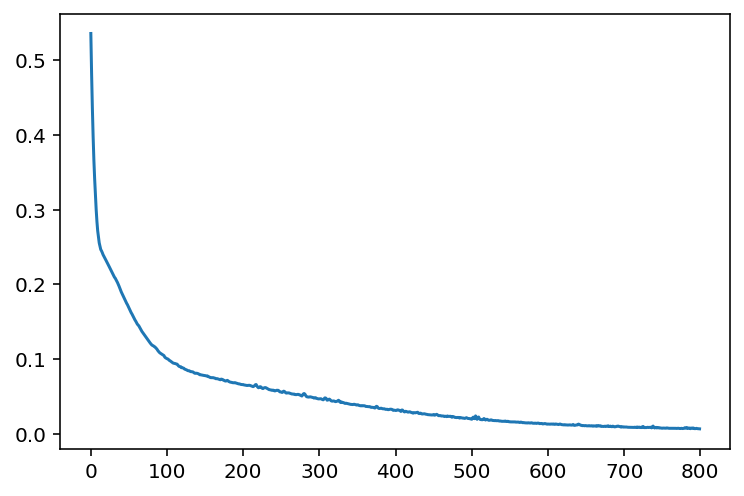

In [48]:
print('Testing NeuralNetwork for regression,', end=' ')
#---------------------------------------------------------------#
X = np.linspace(-1,1,100).reshape((-1, 1))
T = np.sin(X * np.pi)

n_hiddens_list = [10, 10]  # two layer network with 10 units each

nnet = NeuralNetwork(X.shape[1], n_hiddens_list,
                     T.shape[1], activation='tanh')

nnet.train(X, T, n_epochs=800, batch_size=32,
           learning_rate=0.001, optimizer='adam')

Y = nnet.use(X)

print(f'RMSE: {np.sqrt(np.mean((Y - T)**2)):.3f}')
plt.plot(nnet.history['loss'])
plt.show()

### Additional Plotting

In [49]:
rmse = lambda A, B: np.sqrt(np.mean((A - B)**2))

default_font = 14
line_width = 2.5
    
def plot_results(T, Y):
    """Plot target vs predicted with r2 and rmse.
    
    !important: order of params matter.

    :param T: numpy array of target values (N,F)
    :param Y: numpy array of predicted values (N,F)
    :return fig: `matplotlib.pyplot` figure
    :return ax: `matplotlib.pyplot` axis
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(T, Y, '.', color='gray')
    mi = min(min(T), min(Y))
    ma = max(max(T), max(Y))

    ax.plot(np.arange(mi, ma), np.arange(mi, ma), color='blue', linewidth=line_width)

    ax.set_title(f'$R^2$: {r2_score(T, Y):.3f}, RMSE: {rmse(T, Y):.3f} knots',
                 loc='right', fontsize=12, fontstyle='italic')
    ax.set_xlabel('Target Value', fontsize=default_font)
    ax.set_ylabel('Predicted Value', fontsize=default_font)
    ax.tick_params(axis='x', labelsize=default_font)
    ax.tick_params(axis='y', labelsize=default_font)

    ax.grid(True)
    fig.tight_layout()
    return fig, ax

def plot_loss(nnet):
    """Plot learning curves from training.
    
    :param nnet: trained NeuralNetwork class
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(nnet.history['loss'], label='train', linewidth=line_width)
    ax.plot(nnet.history['val_loss'], label='val', linewidth=line_width)
    ax.set_xlabel('Epochs', fontsize=default_font)
    ax.set_ylabel('Loss', fontsize=default_font)
    ax.grid(True)
    ax.legend(fontsize=default_font)
    fig.tight_layout()

**! IMPORTANT**: be sure to run the cells under [Required Functions](#Required-Functions) for data loading, the modeling class, and basic plotting code.

## Linear Regression

Let's begin by loading our data into numpy arrays...

*Note: this must execute before performing dimensionality reduction.*

In [51]:
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition_and_load_data()
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((5639, 128, 128, 1),
 (5639, 1),
 (1386, 128, 128, 1),
 (1386, 1),
 (4438, 128, 128, 1),
 (4438, 1))

Linear regression over the raw input pixels is feasiable, but is subject to a high dimensional input space and is prone to overfit as the number of features, $p$, exceed the number of samples, $n$. One method of regularizating our model is to reduce the number of features such that $p \ll n$. This not only helps prevent overfitting, but also allows us to use familiar feature importance methods to explain model predictions. 

For dimensionality reduction we use Principal Component Analysis (PCA) to transform our spatially correlated variables into uncorrelated variables, namely Principal Components (PC)s, while keeping as much of the variability in the original data as possible.

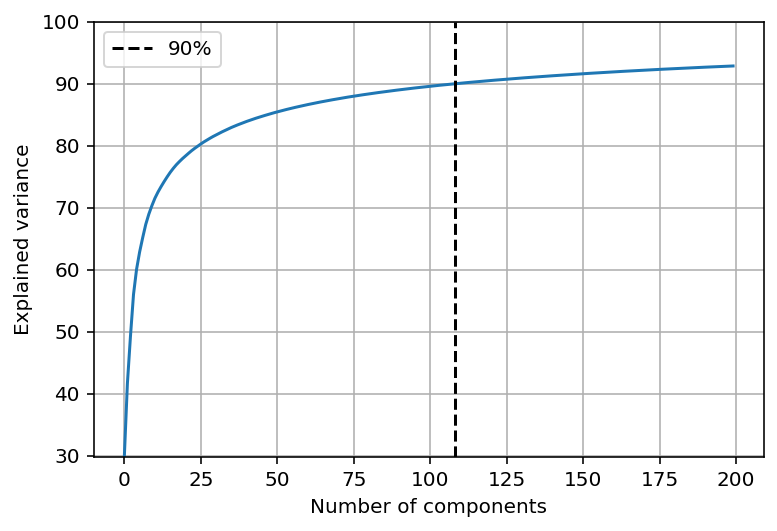

In [52]:
# Note: this will take a minute to compute the large number of components
pca_full = PCA(n_components=200)
pca_full.fit(Xtrain.reshape(Xtrain.shape[0], -1))

explain_var = np.cumsum(pca_full.explained_variance_ratio_ * 100)
plt.plot(explain_var)
plt.ylim(explain_var.min(), 100)
plt.vlines(np.argmin(abs(explain_var - 90)), explain_var.min(), 100,
           linestyle='--', color='black', label='90%')
plt.grid()
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.legend()
plt.show()

We can see that 90% of the variablity in the original data is caputured in the first ~100 components. However, even the first 20 PCs could sufficiently represent the spatial structure at the cost of lossing small detail (or unrelated noise). 

Let's try projecting our input to this much smaller feature space by training PCA on the training data and transforming the other datasets. First, let's first visualize a single sample...

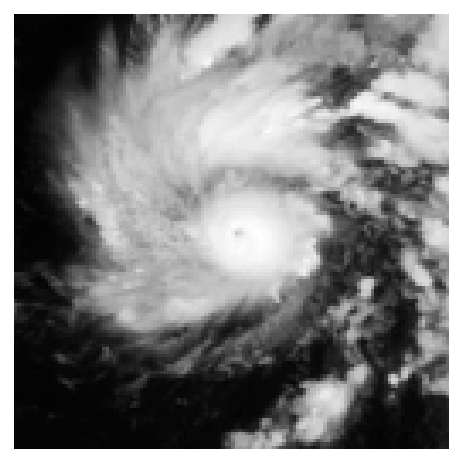

In [53]:
s = 40
plt.imshow(Xtrain[s,:,:,0], cmap='gray')
plt.axis('off');

In [54]:
pca = PCA(n_components=18).fit(Xtrain.reshape(Xtrain.shape[0], -1))
Xtrain = pca.transform(Xtrain.reshape(Xtrain.shape[0], -1))
Xval   = pca.transform(Xval.reshape(Xval.shape[0], -1))
Xtest  = pca.transform(Xtest.reshape(Xtest.shape[0], -1))
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((5639, 18), (5639, 1), (1386, 18), (1386, 1), (4438, 18), (4438, 1))

We can now transform the data back to its original space by using the reduced features and the inverse transform. Visualizing the same sample as above gives us an image with structural support but less detail.

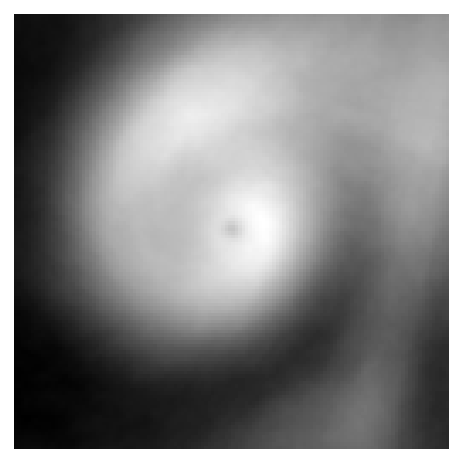

In [55]:
plt.imshow(pca.inverse_transform(Xtrain[s]).reshape(W,H), cmap='gray')
plt.axis('off');

We could make our model *slightly* nonlinear by making the features cubic. The equation for the output of this model (simplified to using a single PC, $x$) for the $i^{th}$ sample is

$$ y_i = w_0 + w_1 x_i + w_2 x_i^2 + w_3 x_i^3$$

*Note: this code is commented out to better visualize and explain the weights of our model corresponding to individual PCs, i.e., the [Model Visualizations](#Model-Visualizations) section will not run properly. Feel free to uncomment and see how the models performance changes.*

In [56]:
# Xtrain = np.hstack((Xtrain, Xtrain**2, Xtrain**3))
# Xval   = np.hstack((Xval, Xval**2, Xval**3))
# Xtest  = np.hstack((Xtest, Xtest**2, Xtest**3))
# Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

Using the `NeuralNetwork` class we construct a model with no hidden layers (i.e., `n_hiddens_list = [0]`) and a single linear output layer. With gradient descent we can find the weights that minimize the mean squared error between our target and predicted values.

Before training starts we standardize the input, $x$, and target, $t$, to have a mean of zero and unit variance (z-score normalization). Every feature and each observational are standardized independently by subtracting the mean and dividing by the standard deviation from the statistics of the training data.

In [57]:
# -----------------------
# init network
n_inputs = Xtrain.shape[1:]
n_hiddens_list = [0]
n_outputs = Ttrain.shape[1]

nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs, seed=None)
nnet.summary()

# -----------------------
# train network
n_epochs = 50
batch_size = 32
optimizer = 'adam'
learning_rate = 0.001
loss_f = 'mse'

nnet.train(Xtrain, Ttrain, n_epochs, batch_size, optimizer,
           learning_rate, loss_f, validation=(Xval, Tval), 
           standardize_x=True, standardize_t=True, verbose=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 flatten (Flatten)           (None, 18)                0         
                                                                 
 out (Dense)                 (None, 1)                 19        
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
epoch: 0, rmse 1.28561, val_rmse 0.88362
epoch: 10, rmse 0.77221, val_rmse 0.54864
epoch: 20, rmse 0.77204, val_rmse 0.54845
epoch: 30, rmse 0.77205, val_rmse 0.55010
epoch: 40, rmse 0.77195, val_rmse 0.54669
epoch: 49, rmse 0.77209, val_rmse 0.54864
finished!


NeuralNetwork((18,), [0], 1)
  Final objective value is 0.59612 in 15.4295 seconds.

Visualizing our loss over training shows the weights have sufficiently converged.

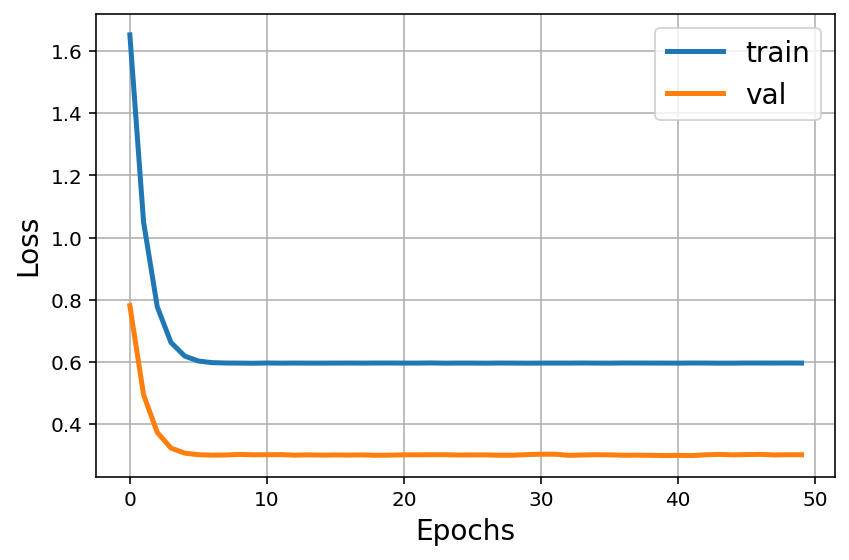

In [58]:
plot_loss(nnet)

Let's use our trained model on the test data for evaluation. This function will standardize the input, compute estimates, and unstandardize these output values to be in the proper units.

In [59]:
Ytest = nnet.use(Xtest)

139/139 [==============================] - 0s 799us/step


Model predictions of wind speed are plotted against the ground truth values. A one-to-one line (in solid blue) represents estimated values that are identical to the target. R$^2$ and RMSE metrics are reported for the estimates and shown in the top right of the figure. Our linear model does *okay* at capturing wind speeds between [25, ~75] knots, but evidently struggles to capture the events with higher speeds.

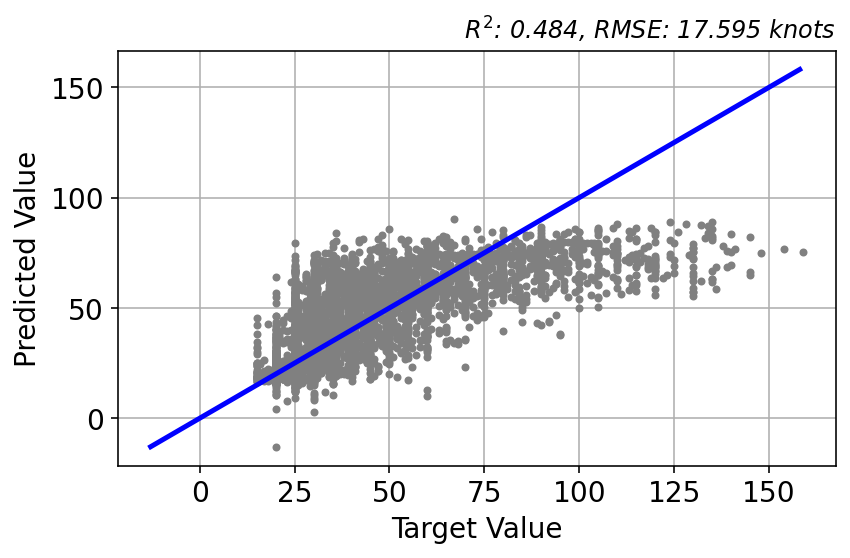

In [60]:
plot_results(Ttest, Ytest);

### Model Visualizations

To visualize our weights in the input space, we reconstruct the spatial domain by combining each PC multiplied by the corresponding weights. This does not consider the bias in our linear model, but can be done as follows.

In [62]:
layer = 'out'
weights, biases = nnet.model.get_layer(layer).get_weights()

pca_map = (pca.components_.T @ weights).reshape(W,H)

print(f'components={pca.components_.T.shape}, weights={weights.shape}, map={pca_map.shape}')

components=(16384, 18), weights=(18, 1), map=(128, 128)


The spatial map below is not surprising; indicates that higher pixel-value intensity (of satellite imagery) near the center of the frame and around the eyewall are strongly positively related to an increase in wind speed. Additionally, there are slight clockwise spirals out from the center with positive correlation to an increase in wind speed. This may correspond to increasing intensity and development patterns of the cyclones. 

*Note: try running this [section](#Linear-Regression) again and increasing the number of PCs (e.g. `PCA(n_components=100)`) when preprocessing the datasets and see how this figure changes. What additional insights can you glean from the increase in spatial detail?*

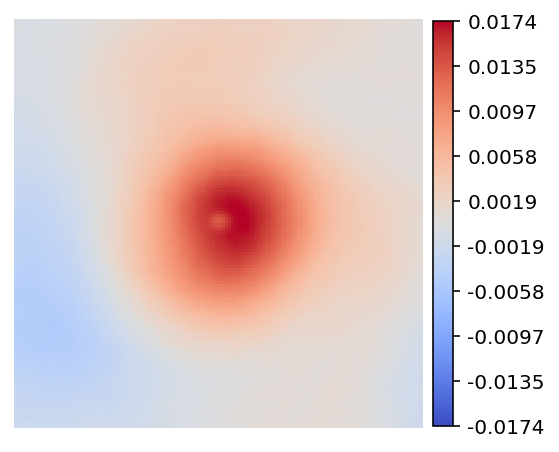

In [63]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
v = max(abs(pca_map.min()), abs(pca_map.max()))
im = ax.imshow(pca_map, vmin=-v, vmax=v, cmap='coolwarm')
cbar = fig.colorbar(im, pad=0.02, shrink=0.76, format='%.4f')
cbar.set_ticks(np.linspace(-v, v, 10))
ax.axis('off')

fig.tight_layout()

### Permutation Importance

Permutation importance is a technique where we shuffle the values of a feature and use the model to see how the scores (e.g. error, loss, etc.) get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

With the `permutation_importance` function we run `n_iterations` of permuting a single feature and record the score to get a better representation of importance. This is done over all the features in the test set.

In [64]:
def permutation_importance(nnet, X, T, n_iterations=10):
    baseline = rmse(nnet.use(X), T)
    n_features = X.shape[1]
    scores = {f: [] for f in range(n_features)}
    indices = np.arange(X.shape[0])
    for f in tqdm.tqdm(range(n_features)):
        Xc = copy.deepcopy(X)
        for _ in range(n_iterations):
            # 1. randomly shuffle feature, f, over all samples
            np.random.shuffle(Xc[:,f])
            # 2. compute estimate using permuted samples
            Y = nnet.use(Xc)
            # 3. calculate score
            score = rmse(Y, T)
            # 4. subtract score from baseline and store value
            scores[f].append(score - baseline)
    return baseline, scores

In [65]:
baseline, scores = permutation_importance(nnet, Xtest, Ttest, n_iterations=10)

139/139 [==============================] - 0s 816us/step


  0%|                                                                                                                                       | 0/18 [00:00<?, ?it/s]

139/139 [==============================] - 0s 807us/step


  6%|███████                                                                                                                        | 1/18 [00:01<00:30,  1.79s/it]

139/139 [==============================] - 0s 805us/step


 11%|██████████████                                                                                                                 | 2/18 [00:03<00:28,  1.78s/it]

139/139 [==============================] - 0s 831us/step


 17%|█████████████████████▏                                                                                                         | 3/18 [00:05<00:26,  1.79s/it]

139/139 [==============================] - 0s 815us/step


 22%|████████████████████████████▏                                                                                                  | 4/18 [00:07<00:25,  1.79s/it]

139/139 [==============================] - 0s 842us/step


 28%|███████████████████████████████████▎                                                                                           | 5/18 [00:08<00:23,  1.79s/it]

139/139 [==============================] - 0s 819us/step


 33%|██████████████████████████████████████████▎                                                                                    | 6/18 [00:10<00:21,  1.79s/it]

139/139 [==============================] - 0s 823us/step


 39%|█████████████████████████████████████████████████▍                                                                             | 7/18 [00:12<00:19,  1.80s/it]

139/139 [==============================] - 0s 816us/step


 44%|████████████████████████████████████████████████████████▍                                                                      | 8/18 [00:14<00:18,  1.80s/it]

139/139 [==============================] - 0s 810us/step


 50%|███████████████████████████████████████████████████████████████▌                                                               | 9/18 [00:16<00:16,  1.80s/it]

139/139 [==============================] - 0s 813us/step


 56%|██████████████████████████████████████████████████████████████████████                                                        | 10/18 [00:17<00:14,  1.81s/it]

139/139 [==============================] - 0s 1ms/step


 61%|█████████████████████████████████████████████████████████████████████████████                                                 | 11/18 [00:19<00:12,  1.82s/it]

139/139 [==============================] - 0s 660us/step


 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 12/18 [00:21<00:10,  1.78s/it]

139/139 [==============================] - 0s 655us/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████                                   | 13/18 [00:23<00:08,  1.72s/it]

139/139 [==============================] - 0s 665us/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                            | 14/18 [00:24<00:06,  1.68s/it]

139/139 [==============================] - 0s 669us/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 15/18 [00:26<00:05,  1.67s/it]

139/139 [==============================] - 0s 823us/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 16/18 [00:28<00:03,  1.72s/it]

139/139 [==============================] - 0s 818us/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 17/18 [00:29<00:01,  1.74s/it]

139/139 [==============================] - 0s 838us/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:31<00:00,  1.77s/it]


For each feature we compute the ratio of change in error (i.e. RMSE) over the baseline and take the mean over all iterations into the `changes` list. Thereafter, we sort the importance of each feature by the highest change and plot the result.

In [66]:
changes = np.zeros(len(scores))
for k,v in scores.items(): # get average over iterations
    changes[k] = (v / baseline * 100).mean()

feature_names = np.array([f'$PC_{{{i:0>2}}}$' for i in range(len(scores))])
top_n = len(scores)  # number of features to display

# -----------------------
# sort by largest change
sorted_indices = np.argsort(changes)[::-1][:top_n]
feature_names = feature_names[sorted_indices]
changes = changes[sorted_indices]

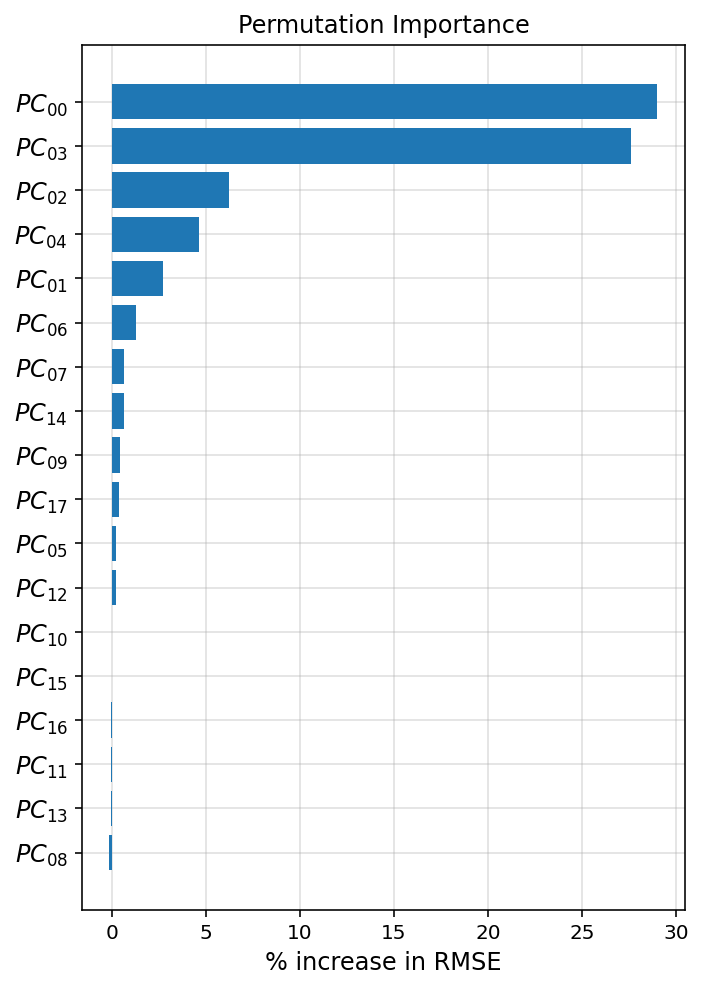

In [67]:
inds = np.arange(len(changes))

fig, ax = plt.subplots(1,1, figsize=(5,7))
ax.barh(inds, changes, color='tab:blue', zorder=3)

ax.set_yticks(inds)
ax.set_yticklabels(feature_names, fontsize=12)
ax.set_xlabel('% increase in RMSE', fontsize=12)
ax.set_title('Permutation Importance')

ax.invert_yaxis()
ax.grid(alpha=0.4, zorder=0)

fig.tight_layout()

The permutation importance shows that by shuffling around the $PC_0$ and $PC_3$ features with other samples in the dataset we get a significant increase in error over the baseline. There is a similar trend with the other components, that is, the earlier PCs have greater importance on the model's prediction. Conversely, later PCs show negligible change in error and have lower importance.

### Shapley Values

SHAP (SHapley Additive exPlanations) is a relatively recent method used to explain individual predictions and provide a global view on the importance of features. SHAP is based on the game theoretically optimal Shapley values. In this notebook we omit the deep dive on theory and focus on the application and explanations.

We begin by initializing our explainer over `n_samples` of the training data. The training data is used as a background dataset to use for integrating out features. We do not need the full dataset for this, but rather a subset of the data (e.g. 100-1000 random samples). We will also compute our SHAP values for the test data. This can be a computationally expensive task as the number of samples and/or features increase, but luckily our test set does not have many.

In [68]:
n_samples = 500
inds = np.arange(len(Xtrain))
np.random.shuffle(inds)
inds = inds[:n_samples]

feature_names = np.array([f'$PC_{{{i:0>2}}}$' for i in range(Xtrain.shape[1])])

e = shap.DeepExplainer(nnet.model, data=nnet._standardizeX(Xtrain)[inds])
shap_values = e.shap_values(nnet._standardizeX(Xtest))[0]

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


SHAP feature importance is an alternative to the permutation feature importance that we explored previously. The difference between the two is that permutation importance is based on the decrease of model performance, whereas SHAP is based on magnitude of feature attributions, i.e. the mean absolute value of the SHAP values for each feature.

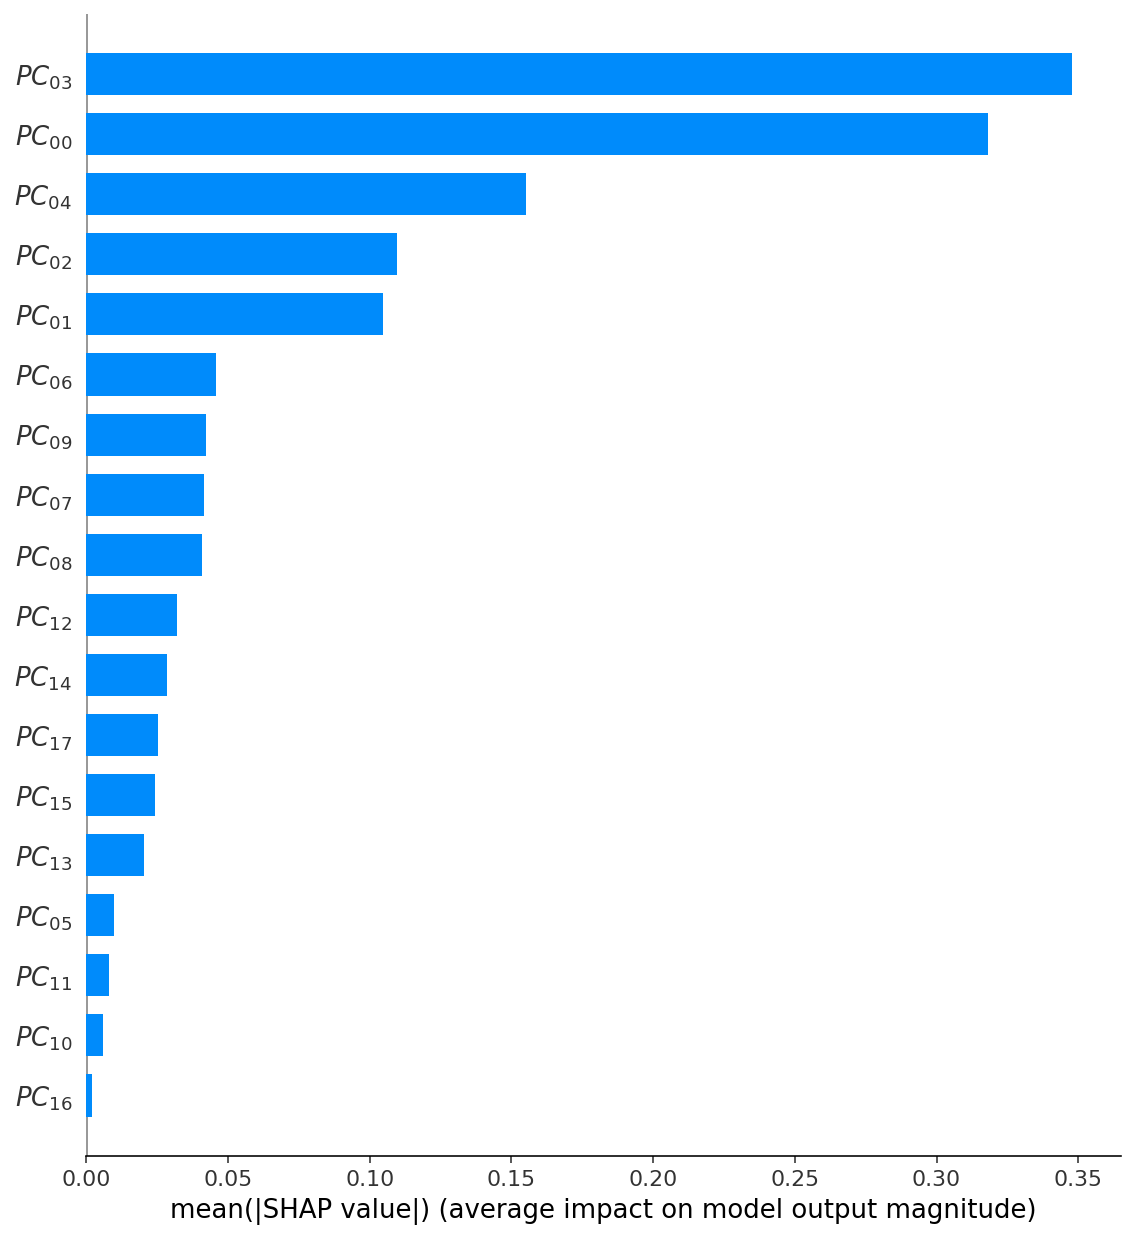

In [69]:
shap.summary_plot(shap_values, features=nnet._standardizeX(Xtest), 
                  feature_names=feature_names, plot_type='bar')

The SHAP feature importance plot is similar to the bar graph of permutation importance, albeit with higher magnitude and slight reordering of features. While this is useful, it lacks information beyond the importances. For a more informative plot, we will next look at the summary (or beeswarm) plot.

Here, feature importance and feature effects are combined, showing each Shapley value for a given feature and sample as a single point. Overlapping points are jittered on the y-axis to show density for a given feature. The color represents the actual value of the feature (i.e. red=high and blue=low). The features are also ordered by their importance values, calculated the same way as in the bar graph above.

We can see that having a high value for $PC_3$ is associated with a decrease in the model's output. Whereas a high value for $PC_0$ is positively correlated with an increase of model output. 

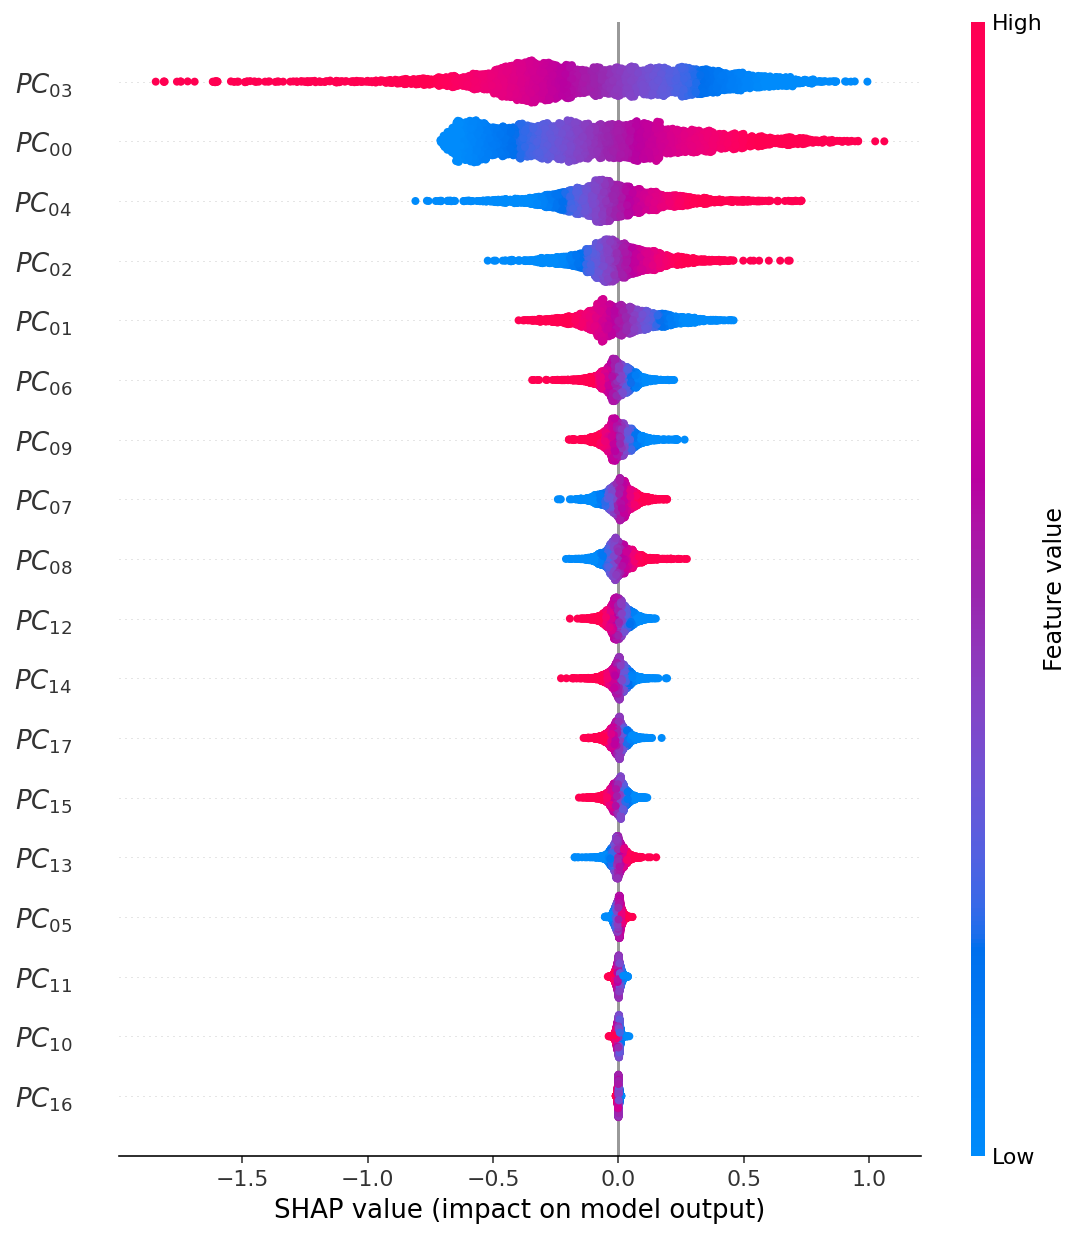

In [70]:
shap.summary_plot(shap_values, features=nnet._standardizeX(Xtest), 
                  feature_names=feature_names, plot_type='dot')

# DAY 2

**! IMPORTANT**: be sure to run the cells under [Required Functions](#Required-Functions) for data loading, the modeling class, plotting, and basic plotting code.

## Convolutional Neural Network

While our linear model has vew few parameters and can easily be explained, it lacks some of the performance properties we hope for in this problem. Specifically, it is important that our model is able to accurately estimate the highest wind speeds, all the while generalizing over the distribution of possible values.

Using a Convolutional Neural Network (CNN), we can better capture the spatial relationships within our imagery. This model also introduces non-linearity into the network, which in turn, allows us to model our targets that vary non-linearly with the raw input pixels.

Let's begin by loading in the data and inspecting the shape...

In [ ]:
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition_and_load_data()
print(f'X.min={Xtrain.min()}, X.max={Xtrain.max()}')
print(f'T.min={Ttrain.min()}, T.max={Ttrain.max()}')
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

We can use our handy `NeuralNetwork` class to initialize a CNN by including the `conv_layers` parameter. Here, we specify three convolutional layers having an increase in the number of filters (`n_units`) all with `shape` $3 \times 3$ filters. Each convoltuion is followed by the Rectified Linear Unit (ReLU) activation and max pooling. After the convolutions is a single non-linear fully-connected layer before the linear output layer. Do look at the output of `nnet.summary()` to see the other details of the model.

In the call to `nnet.train` we standardize our target wind speed, $T$, but do *not* standardize our input images, $X$, as they are already normalized between the values of [0, 1].

In [ ]:
# -----------------------
# init network
n_inputs = Xtrain.shape[1:]
conv_layers = [{'n_units': 8, 'shape': [3, 3]},
               {'n_units': 16, 'shape': [3, 3]},
               {'n_units': 32, 'shape': [3, 3]}]
n_hiddens_list = [64]
n_outputs = Ttrain.shape[1]
activation = 'relu'

nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs, conv_layers, 
                     activation, seed=111)
nnet.summary()

# -----------------------
# train network
n_epochs = 10
batch_size = 32
optimizer = 'adam'
learning_rate = 0.001
loss_f = 'mse'

nnet.train(Xtrain, Ttrain, n_epochs, batch_size, optimizer,
           learning_rate, loss_f, validation=(Xval, Tval),
           standardize_x=False, standardize_t=True, verbose=True)

Looking at the learning curves with the training and validation loss, we can see the validation error decrease slightly before it plateaus around a constant value. The training loss continues to go decrease, but we do not want the model to overfit, so we do not train for very long.

In [ ]:
plot_loss(nnet)

Let's use our model on the **test** set. The function call to `nnet.use` will unstandardize the estimates back to the original units.

In [ ]:
Ytest = nnet.use(Xtest)

We can now plot our target vs predicted values and compute our basic evaluation metrics. Most notably is the higher $R^2$ and lower RMSE than our linear model. A significant improvement can be seen with higher wind speeds, where the network's prediction are closer to the target value.

In [ ]:
plot_results(Ttest, Ytest);

Let's inspect our performance diagram...

In [ ]:
plot_performance_diagram_helper(Ttest, Ytest)

### Network Visualizations

Two methods to make our CNN slightly more transparent is to (1) inspect the convolutional filter weights to discover the type of spatial features the model detects, and (2) the activation maps (or output feature maps) to understand the features that propagate for a given input image.

First, let's see what layers we have to look at...

In [ ]:
layers = nnet.model.layers
index = 0
for i, layer in enumerate(layers):
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(f'\033[1m index={index}\033[0m: layer.name={layer.name}, filters={filters.shape} -> {layers[i+1].name}')
    index += 1

**Activity:** try changing the index from `0` to one of the deeper layers listed above, i.e. `1 or 2`, and then rerun the cells below. What kind of changes do you observe with the filter weights and activation maps? Are they easier or harder to interpret in later laters?

In [ ]:
index = 0

# -----------------------
# get layers
subscript = f'_{index}' if index > 0 else ''
conv_layer = 'conv2d' + subscript
activation_layer = 'activation' + subscript
conv_layer, activation_layer

These functions will help us with extracting the weights and activatin maps as well as with plotting.

In [ ]:
def plot_filter_weights(conv_layer, scale=1.2):
    filters, biases = nnet.model.get_layer(conv_layer).get_weights()
    n_filters = filters.shape[-1]
    
    # rest for plotting
    fig = plt.figure(figsize=(4*scale, n_filters//4*scale), constrained_layout=True)
    for i in range(n_filters):
        f = filters[:, :, :, i]
        ax = plt.subplot(n_filters//4, 4, i+1)
        plt.imshow(f[:, :, 0], vmin=filters.min(), vmax=filters.max(), 
                   cmap='gray')
        ax.axis('off')
    plt.show()

def plot_activation_map(activation_layer, x, scale=1.2):
    lmodel = tf.keras.models.Model(nnet.model.inputs, 
                                   nnet.model.get_layer(activation_layer).output)
    z = lmodel(np.array([x])).numpy()
    n_outputs = z.shape[-1]
    
    # rest for plotting
    fig = plt.figure(figsize=(4*scale, n_outputs//4*scale), constrained_layout=True)
    for i in range(n_outputs):
        f = z[0, :, :, i]
        ax = plt.subplot(n_outputs//4, 4, i+1)
        # add args to equally compare filters: vmin=z.min(), vmax=z.max()
        plt.imshow(f[:, :], cmap='gray') 
        ax.axis('off')
    plt.show()

Plotting the weights of all filters in the convolutional layer. They each have size $3 \times 3$ as was specified when we initialized our CNN. These weights are fixed after training and independent of the samples.

In [ ]:
plot_filter_weights(conv_layer)

The activation maps illustrates the intermediate output of our model after applying the filters and activation function of this layer (and those prior) to the input. Thus, we will specify an input and perform partial forward pass through our network and plot these individual values.

In [ ]:
sample = 40
x = Xtrain[sample]
t = Ttrain[sample,0]

plt.imshow(x[:,:,0],cmap='gray')
plt.text(5, 12, t, color='yellow', weight='bold', fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
plot_activation_map(activation_layer, x)

Both methods can offer some insight to the network but are insufficent at explaining the prediction of the model. A primary reason for this is that the fully-connected and output layers remove the spatial relationships of activation maps and may dampen (increase) the high (low) value activations from the convolutional layers.

### Saliency

We are using the [PAIR saliency](https://github.com/PAIR-code/saliency) package to assist with computing state-of-the-art explainations (e.g. XRAI, BlurIG, SmoothGrad, and more) from our TensorFlow models. 

Documentation and additional details can be found here: https://pair-code.github.io/saliency/#home



In [ ]:
unit_output_str = 'unit_output_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_idx = call_model_args[unit_output_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = xmodel(images)
            output_layer = output_layer[:,target_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = xmodel(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}
        
def show_grayscale(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    plt.title(title)
    
def show_heatmap(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap='inferno')
    plt.title(title)

In [ ]:
conv_layer = nnet.model.get_layer('conv2d_2')
xmodel = tf.keras.models.Model([nnet.model.inputs], 
                               [conv_layer.output, nnet.model.output])

sample = 40
x = Xtrain[sample]
t = Ttrain[sample,0]
_, y = xmodel(np.array([x]))
y = nnet._unstandardizeT(y).numpy()[0,0]

call_model_args = {unit_output_str: 0}

#### Integrated Gradients & SmoothGrad

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(x, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(x, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

ROWS = 1
COLS = 3
UPSCALE_FACTOR = 9
fig = plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

show_grayscale(x[:,:,0], title=f'Original Image, t={t:.2f} y={y:.2f}',
               ax=plt.subplot(ROWS, COLS, 1))
show_grayscale(vanilla_mask_grayscale,
               title='Vanilla Gradient', ax=plt.subplot(ROWS, COLS, 2))
show_grayscale(smoothgrad_mask_grayscale,
               title='SmoothGrad', ax=plt.subplot(ROWS, COLS, 3))
fig.tight_layout()

#### XRAI

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(x, call_model_function, call_model_args, batch_size=20)

ROWS = 1
COLS = 3
UPSCALE_FACTOR = 9
fig = plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

show_grayscale(x[:,:,0], title=f'Original Image, t={t:.2f} y={y:.2f}',
               ax=plt.subplot(ROWS, COLS, 1))
show_heatmap(xrai_attributions, title='XRAI Heatmap', ax=plt.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
im_mask = np.array(x[:,:,0])
im_mask[~mask] = 0
show_grayscale(im_mask, title='Top 30%', ax=plt.subplot(ROWS, COLS, 3))
fig.tight_layout()

#### Grad-CAM

In [ ]:
# Compare Grad-CAM and Smoothgrad with Grad-CAM.

# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(x, call_model_function, call_model_args)
smooth_grad_cam_mask_grayscale = grad_cam.GetSmoothedMask(x[:,:,0], call_model_function, 
                                                          call_model_args,  three_dims=False)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)

ROWS = 1
COLS = 3
UPSCALE_FACTOR = 9
fig = plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

show_grayscale(x[:,:,0], title=f'Original Image, t={t:.2f} y={y:.2f}',
               ax=plt.subplot(ROWS, COLS, 1))
show_grayscale(grad_cam_mask_grayscale, 
               title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 2))
show_grayscale(smooth_grad_cam_mask_grayscale, 
               title='Smoothgrad Grad-CAM', ax=plt.subplot(ROWS, COLS, 3))

fig.tight_layout()

#### Guided IG

In [ ]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients()
guided_ig = saliency.GuidedIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(x.shape)

# Compute the vanilla mask and the Guided IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  x, call_model_function, call_model_args, 
    x_steps=25, x_baseline=baseline, batch_size=20
)
guided_ig_mask_3d = guided_ig.GetMask(
  x, call_model_function, call_model_args, 
    x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5
)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

ROWS = 1
COLS = 3
UPSCALE_FACTOR = 9
fig = plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

show_grayscale(x[:,:,0], title=f'Original Image, t={t:.2f} y={y:.2f}',
               ax=plt.subplot(ROWS, COLS, 1))
show_grayscale(vanilla_mask_grayscale,
               title='Vanilla Integrated Gradients', ax=plt.subplot(ROWS, COLS, 2))
show_grayscale(guided_ig_mask_grayscale,
               title='Guided Integrated Gradients', ax=plt.subplot(ROWS, COLS, 3))
fig.tight_layout()

#### Blur IG

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()
blur_ig = saliency.BlurIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(x.shape)

# Compute the vanilla mask and the Blur IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  x, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
blur_ig_mask_3d = blur_ig.GetMask(
  x, call_model_function, call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

ROWS = 1
COLS = 3
UPSCALE_FACTOR = 9
fig = plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

show_grayscale(x[:,:,0], title=f'Original Image, t={t:.2f} y={y:.2f}',
               ax=plt.subplot(ROWS, COLS, 1))
show_grayscale(vanilla_mask_grayscale, 
                   title='Vanilla Integrated Gradients', ax=plt.subplot(ROWS, COLS,2))
show_grayscale(blur_ig_mask_grayscale, 
                   title='Blur Integrated Gradients', ax=plt.subplot(ROWS, COLS, 3))
fig.tight_layout()

In [ ]:
# Compare BlurIG and Smoothgrad with BlurIG. Note: This will take a long time to run.

# Construct the saliency object. This alone doesn't do anthing.
blur_ig = saliency.BlurIG()

# Compute the Blur IG mask and Smoothgrad+BlurIG mask.
blur_ig_mask_3d = blur_ig.GetMask(x, call_model_function, call_model_args, 
                                  batch_size=20)
# Smoothed mask for BlurIG will take a while since we are 
# doing nsamples * nsamples computations.
smooth_blur_ig_mask_3d = blur_ig.GetSmoothedMask(x, call_model_function, 
                                                 call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
smooth_blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_blur_ig_mask_3d)

ROWS = 1
COLS = 3
UPSCALE_FACTOR = 9
fig = plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

show_grayscale(x[:,:,0], title=f'Original Image, t={t:.2f} y={y:.2f}',
               ax=plt.subplot(ROWS, COLS, 1))
show_grayscale(blur_ig_mask_grayscale, 
               title='Blur Integrated Gradients', ax=plt.subplot(ROWS, COLS, 2))
show_grayscale(smooth_blur_ig_mask_grayscale, 
               title='Smoothgrad Blur IG', ax=plt.subplot(ROWS, COLS, 3))
fig.tight_layout()

# DAY 3

## Case Studies

#### Storm Type

Divide samples into three groups based on their (true) labels:  weak (< 65 knots);  medium (65-85 knots);  strong (> 85 knots). Test performance of the NN separately for each group.  These labels are based on intensity classification, and weak, medium, and strong storms sometimes behave differently. 

In [ ]:
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition_and_load_data()
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

In [ ]:
# -----------------------
# init network
n_inputs = Xtrain.shape[1:]
conv_layers = [{'n_units': 8, 'shape': [3, 3]},
               {'n_units': 16, 'shape': [3, 3]},
               {'n_units': 32, 'shape': [3, 3]}]
n_hiddens_list = [64]
n_outputs = Ttrain.shape[1]
activation = 'relu'

nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs, conv_layers, 
                     activation, seed=111)
# nnet.summary()

# -----------------------
# train network
n_epochs = 10
batch_size = 32
optimizer = 'adam'
learning_rate = 0.001
loss_f = 'mse'

nnet.train(Xtrain, Ttrain, n_epochs, batch_size, optimizer,
           learning_rate, loss_f, validation=(Xval, Tval),
           standardize_x=False, standardize_t=True, verbose=True)

In [ ]:
Ytest = nnet.use(Xtest)

In [ ]:
ranges = ((-np.inf, 65),
          (65, 85),
          (85, np.inf))

for i, r in enumerate(ranges):
    indices = np.where((r[0] <= Ytest) & (Ytest < r[1]))[0]
    fig, ax = plot_results(Ttest[indices], Ytest[indices])
    ax.set_title(f'{chr(97+i)}) {r}', weight='bold', loc='left')

#### Geographic exploration 

Explore performance in different geographical regions. Train NN in both Western and Eastern basin. Then test in each basin separately and record performance. Difference in performance? What could be the reason?  

In [ ]:
train_df = pd.read_csv(DATA_PATH / 'train_metadata.csv')
test_df = pd.read_csv(DATA_PATH / 'test_metadata.csv')
train, val, test = partition_data(train_df, test_df)
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = load_data(train, val, test)

In [ ]:
test.head()

In [ ]:
atlantic = 1
east_pacific = 2

test_atlantic_indices = test.index[test.ocean == atlantic].values
test_pacific_indices = test.index[test.ocean == east_pacific].values
len(test_atlantic_indices), len(test_pacific_indices)

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = sns.boxplot(x=test.wind_speed, y=test.ocean.astype(str), color='lightgray')
ax.set_yticklabels(['Atlantic','East Pacific'])
ax.set_xlabel('Wind Speed')
ax.set_title('Distribution of Wind Speeds by Ocean')
fig.tight_layout()

In [ ]:
nrows = 4
fig, axs = plt.subplots(nrows, 2, figsize=(4,8), constrained_layout=True)
for i, (atlantic_i, pacific_i) in enumerate(zip(test_atlantic_indices[:nrows], 
                                                test_pacific_indices[:nrows])):
    axs[i,0].imshow(Xtest[atlantic_i,:,:,0], cmap='gray')
    axs[i,0].text(5, 15, Ttest[atlantic_i,0], 
                  color='yellow', weight='bold', fontsize=14)
    
    axs[i,1].imshow(Xtest[pacific_i,:,:,0], cmap='gray')
    axs[i,1].text(5, 15, Ttest[pacific_i,0], 
                  color='yellow', weight='bold', fontsize=14)
    
for ax in axs.ravel():
    ax.axis('off')

Recall with NumPy we can index our array with an array of indices, e.g.

In [ ]:
Ttest[test_atlantic_indices].shape, Ttest[test_pacific_indices].shape

In [ ]:
# TODO: train a network and evaulate on the different oceans